In [12]:


import matplotlib.pyplot as plt
from cyipopt import minimize_ipopt
from scipy.optimize._numdiff import approx_derivative

from jax.config import config
# enable 64 bit floating point precision
config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jacfwd, jit


# z = (x1(t0) .... x1(tN) x2(t0) .... x2(tN) v(t0) .... v(tN))^T

# time grid
tspan = [0, 12]
dt    = 0.1
time  = np.arange(tspan[0], tspan[1] + dt, dt)

N = time.size


def objective(z):
    x0, x1, v = np.split(z, 3)
    return dt*(np.sum((x0[0:-1]-1)**2)+np.sum((x1[0:-1]-1)**2))
    #res = 0.0
    #for i in range(N-1):
    #    res += dt*((x0[i]-1)**2 + (x1[i]-1)**2)
    #return res


def ode_rhs(x, v):
    x0, x1 = x
    xdot1 = x0 - x0*x1 - 0.4*x0*v
    xdot2 = -x1 + x0*x1 - 0.2*x1*v
    return xdot1, xdot2


def constraint(z):
    x0, x1, v = np.split(z, 3)
    x = np.array([x0, x1])
    res = np.zeros((2, x0.size))

    xdot1, xdot2 = ode_rhs([x0,x1],v)
    # initial values
    res = res.at[:, 0].set(x[:, 0] - np.array([0.5, 0.7]))
    res = res.at[0,1:].set(x[0, 1:] - x[0, 0:-1] - dt*xdot1[0:-1])
    res = res.at[1,1:].set(x[1, 1:] - x[1, 0:-1] - dt*xdot2[0:-1])
    # 'solve' the ode-system
    #for j in range(N-1):
        #h = time[j+1] - time[j]
        # implicite euler scheme
        #res[:, j+1] = x[:, j+1] - x[:, j] - dt*ode_rhs(x[:, j+1], v[j])
    return res.flatten()

z0 = 0.1 + np.zeros(N*3)

ode_jit = jit(ode_rhs)
obj_jit = jit(objective)
con_jit = jit(constraint)

obj_grad = jit(grad(obj_jit))
con_jac = jit(jacfwd(con_jit))

print("Compiling the functions...")
_ = obj_jit(z0), con_jit(z0), obj_grad(z0), con_jac(z0)
print("Done.")
# initial point


# variable bounds
bnds = [(None, None) if i < 2*N else (0, 1) for i in range(z0.size)]

# constraints:
cons = [{
    'type': 'eq',
    'fun': con_jit,
    'jac': con_jac
}]

# call the solver
res = minimize_ipopt(obj_jit, x0=z0, jac=obj_grad,bounds=bnds,
                     constraints=cons, options = {'disp': 5,'linear_solver':'ma27'})


Compiling the functions...
Done.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.6, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    87846
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      363
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      121
                     variables with only upper bounds:        0
Total number of equality constraints.................:      242
Tot

In [3]:
%timeit obj_grad(z0)
%timeit con_jac(z0)

17.3 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
20 µs ± 646 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
from jax import random, pmap
import jax.numpy as jnp

# Create 8 random 5000 x 6000 matrices, one per GPU
keys = random.split(random.PRNGKey(0), 8)
mats = pmap(lambda key: random.normal(key, (5000, 6000)))(keys)

# Run a local matmul on each device in parallel (no data transfer)
result = pmap(lambda x: jnp.dot(x, x.T))(mats)  # result.shape is (8, 5000, 5000)

# Compute the mean on each device in parallel and print the result
print(pmap(jnp.mean)(result))
# prints [1.1566595 1.1805978 ... 1.2321935 1.2015157]

AttributeError: _src

In [13]:
print(res['x'].shape)

(363,)


In [13]:
import casadi
import numpy as np
# time grid
tspan = [0, 12]
dt    = 0.1
times  = np.arange(tspan[0], tspan[1] + dt, dt)

N = len(times)

opti = casadi.Opti()
ca_x1 = opti.variable(N+1)
ca_x2 = opti.variable(N+1)
ca_v = opti.variable(N)


ca_x1_dot = ca_x1[0:-1]-ca_x1[0:-1]*ca_x2[0:-1]-0.4*ca_x1[0:-1]*ca_v
ca_x2_dot = -ca_x2[0:-1]+ca_x1[0:-1]*ca_x2[0:-1]-0.2*ca_x2[0:-1]*ca_v


opti.minimize(casadi.sum1((ca_x1-1)*(ca_x1-1)) + casadi.sum1((ca_x2-1)*(ca_x2-1)))



opti.subject_to(ca_x1[1:]==ca_x1[0:-1]+dt*ca_x1_dot)
opti.subject_to(ca_x2[1:]==ca_x2[0:-1]+dt*ca_x2_dot)
opti.subject_to(opti.bounded(0,ca_v,1))
opti.subject_to(ca_x1[0]==0.5)
opti.subject_to(ca_x2[0]==0.7)

option = {'max_iter': 600000,'linear_solver':'ma57'}

opti.solver('ipopt',{},option)
try:
    sol = opti.solve()
except Exception as e:
    print(e)



This is Ipopt version 3.12.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      970
Number of nonzeros in inequality constraint Jacobian.:      121
Number of nonzeros in Lagrangian Hessian.............:      607

Total number of variables............................:      365
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      244
Total number of inequality constraints...............:      121
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      121
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.4400000e+02 7.00e-01 2.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1

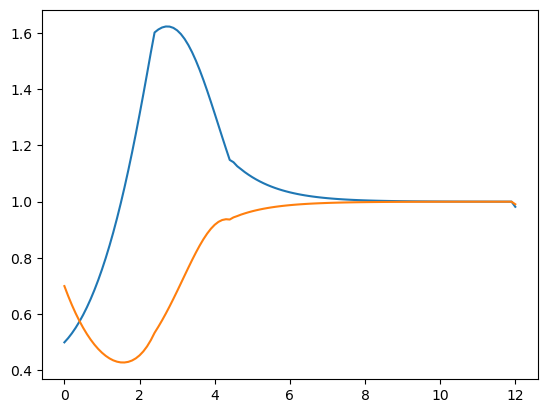

[0.7        0.665      0.6327475  0.60315089 0.57611765 0.55155762
 0.52938587 0.50952508 0.49190768 0.4764779  0.46319367 0.45202865
 0.44297438 0.43604264 0.43126816 0.42871181 0.42846431 0.43065059
 0.43543494 0.44302701 0.45368872 0.46774205 0.48557756 0.50766319
 0.53395234 0.55538334 0.57826191 0.60249884 0.62796367 0.65447933
 0.6818177  0.70969713 0.73778233 0.76568749 0.79298311 0.81920674
 0.84387766 0.86651466 0.88665614 0.90388083 0.91782756 0.92821221
 0.93484043 0.93761497 0.93653716 0.94413529 0.94882208 0.95398391
 0.95831628 0.96235485 0.96596609 0.96924456 0.9722045  0.97487901
 0.97729658 0.97948011 0.98145291 0.98323533 0.98484562 0.98630013
 0.98761444 0.98880202 0.98987513 0.99084475 0.99172105 0.99251314
 0.99322908 0.99387628 0.99446141 0.99499041 0.99546877 0.99590132
 0.99629238 0.99664602 0.99696579 0.99725486 0.99751642 0.99775283
 0.99796669 0.99816006 0.99833498 0.99849319 0.9986363  0.99876572
 0.99888288 0.99898871 0.99908449 0.99917104 0.99924921 0.9993

In [128]:
x0,x1,v = np.split(res['x'],3)
ca_x0 = sol.value(ca_x1)
ca_x1 = sol.value(ca_x2)
ca_v = sol.value(ca_v)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(times,x0)
plt.plot(times,x1)
#plt.plot(times,ca_x0[0:-1])
#plt.plot(times,ca_x1[0:-1])
plt.show()

print(x1)
print(ca_x0)


In [82]:
import jax


3
3
